# **Bank Customer Exit Predictor (CI PP-5)** 

# **ML Modeling : Classification**

## Objectives

* To fit and evaluate a classification based model and predict if a customer will exit or not.

## Inputs

* outputs/datasets/collection/BankCustomerData.csv
* Data cleaning and Feature Engineering conclusions based on respective notebooks.

## Outputs

* Train and Test set (Features and Target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline to predict customer exit
* Feature Importance Plot


---

# Change working directory

* Notebooks are being stored in a subfolder, therefore when running the notebook in the editor, we need to change the working directory from its current folder to parent folder

1. We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/BankCustomerExitPredictor/jupyter_notebooks'

2. We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You have set a new current directory")

You have set a new current directory


3. Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/BankCustomerExitPredictor'

---

# Load Data

*  Loading dataset from outputs folder, however we are not including variables: CustomerID, Surname and RowNumber as they are just identifiers and dont impact the exit study. Also we are  removing Tenure which will be our target variable for regression model.

* We are removing missing data from ['Age', 'Geography', 'HasCrCard', 'IsActiveMember'] as the missing data level is not significant.

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/BankCustomerData.csv")
      .drop(labels=['Tenure', 'CustomerId', 'Surname', 'RowNumber'], axis=1) 
  )
df.dropna(inplace=True) 
print(df.shape)
df.head(3)

(9996, 10)


,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,159660.80,3,1.0,0.0,113931.57,1


---

# ML Pipeline: Classification

### 1. ML Pipeline : Data Cleaning and Feature Engineering

* Basis Data cleaning and Feature Engineering notebooks we prepare a custom pipleline.
* We dont require any data cleaning steps.

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering : Ordinal Encoder ans Transformation
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt


def PipelineDataCleanAndFeatEng():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender', 'Geography'])),
        ("log", vt.LogTransformer(variables=['Age']) )                                              
    ])

    return pipeline_base


PipelineDataCleanAndFeatEng()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('log', LogTransformer(variables=['Age']))])

### 2. ML Pipeline for Modeling and Hyperparameter Optimisation

* We prepare a pipeline for feature scaling and selection

In [6]:
# Standard Scaler for Feature Scaling
from sklearn.preprocessing import StandardScaler

# SelectFromModel for Feature Selection
from sklearn.feature_selection import SelectFromModel

# All ML classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineFeatOpt(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


* For hyperparameter optimisation we use a custom class from Code Institute's Scikit lesson

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineFeatOpt(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

# Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Exited'], axis=1),
    df['Exited'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.info()

(7996, 9) (7996,) (2000, 9) (2000,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7996 entries, 4759 to 2736
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7996 non-null   int64  
 1   Geography        7996 non-null   object 
 2   Gender           7996 non-null   object 
 3   Age              7996 non-null   float64
 4   Balance          7996 non-null   float64
 5   NumOfProducts    7996 non-null   int64  
 6   HasCrCard        7996 non-null   float64
 7   IsActiveMember   7996 non-null   float64
 8   EstimatedSalary  7996 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 624.7+ KB


# Managing Target Imbalance 

1. Fitting train and test sets with Data cleaning and Feat Eng Pipeline.

In [9]:
pipeline_preprocessed = PipelineDataCleanAndFeatEng()
X_train = pipeline_preprocessed.fit_transform(X_train)
X_test = pipeline_preprocessed.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7996, 9) (7996,) (2000, 9) (2000,)


2. Checking target distribution in train set 

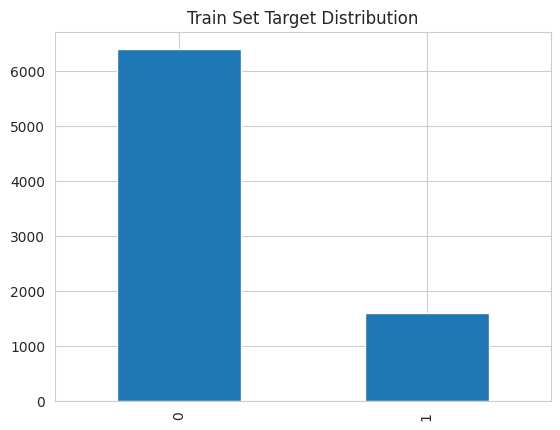

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

* Target variable is not balanced in train set as we have low number of Exited customers cases.

3. Using SMOTE (Synthetic Minority Oversampling Technique) to balance Train Set target

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority',k_neighbors=30, random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12788, 9) (12788,) (2000, 9) (2000,)


4. Checking Train Set Target distribution after resampling

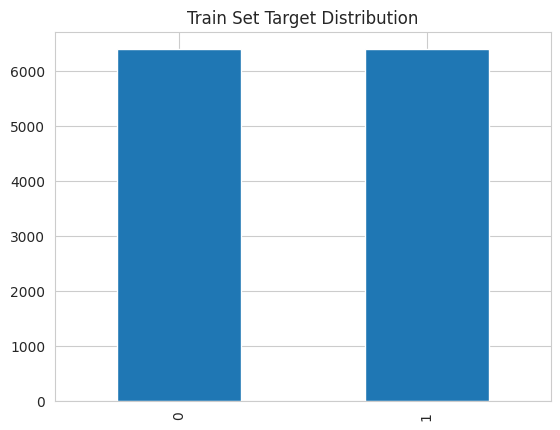

In [12]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

# Grid Search CV - Sklearn

1. Using Algorithms with standard hyperparameters to identify most suitable algorithm

In [13]:
models_default = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

params_default = {
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
}

2. Using make scorer and recall score for Quick GridSearch CV for Binary Classifier

In [14]:
from sklearn.metrics import make_scorer, recall_score
best_alg = HyperparameterOptimizationSearch(models=models_default, params=params_default)
best_alg.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is d


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


3. Checking Score Summary

In [15]:
grid_search_summary, grid_search_pipelines = best_alg.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,GradientBoostingClassifier,0.353401,0.779187,0.917905,0.215251
2,AdaBoostClassifier,0.383894,0.767147,0.902191,0.195874
4,DecisionTreeClassifier,0.153245,0.765905,0.960876,0.310926
5,RandomForestClassifier,0.140735,0.743852,0.932707,0.306054
1,ExtraTreesClassifier,0.125098,0.735874,0.923378,0.30719
3,XGBClassifier,0.0,0.679574,0.879593,0.342548


### Identifying best hyperparameter configuration for top two ML Algorithms

1. Defining top two models and parameters for further analysis

In [16]:
models_search = {
   "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
   "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
}

params_search = {
  "AdaBoostClassifier":{'model__n_estimators': [5,10,15,20],
                          'model__learning_rate':[0.1,0.5,1],
                          'model__algorithm': ['SAMME', 'SAMME.R']
                            },
  "GradientBoostingClassifier":{'model__learning_rate':[.1,.5,1],
                                'model__n_estimators':[5,10,15,20],
                                'model__min_samples_leaf': [1,50],  
                                'model__max_depth': [5,8],
                            }
}

2. Using make scorer and recall score for Quick GridSearch CV for Binary Classifier

In [17]:
from sklearn.metrics import recall_score, make_scorer
best_alg = HyperparameterOptimizationSearch(models=models_search, params=params_search)
best_alg.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


3. Checking Score Summary

In [18]:
grid_search_summary, grid_search_pipelines = best_alg.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__algorithm,model__learning_rate,model__n_estimators,model__max_depth,model__min_samples_leaf
5,AdaBoostClassifier,0.70602,0.822491,0.903831,0.066316,SAMME,0.5,10,NaN,NaN
7,AdaBoostClassifier,0.544175,0.816402,0.909304,0.138025,SAMME,0.5,20,NaN,NaN
9,AdaBoostClassifier,0.577795,0.801232,0.88663,0.11697,SAMME,1,10,NaN,NaN
6,AdaBoostClassifier,0.612197,0.799981,0.878717,0.096342,SAMME,0.5,15,NaN,NaN
71,GradientBoostingClassifier,0.173573,0.794212,0.989054,0.314763,NaN,1,20,8,50
...,...,...,...,...,...,...,...,...,...,...
18,AdaBoostClassifier,0.434715,0.727107,0.849765,0.156022,SAMME.R,0.5,15,NaN,NaN
16,AdaBoostClassifier,0.434715,0.716147,0.821736,0.142778,SAMME.R,0.5,5,NaN,NaN
14,AdaBoostClassifier,0.481626,0.713649,0.78482,0.116721,SAMME.R,0.1,15,NaN,NaN
15,AdaBoostClassifier,0.481626,0.704421,0.771697,0.112268,SAMME.R,0.1,20,NaN,NaN


4. Identifying best model 

In [19]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

5. Identifying best parameters

In [20]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__algorithm': 'SAMME',
 'model__learning_rate': 0.5,
 'model__n_estimators': 10}

6. Defining best classification pipeline basis extensive search

In [21]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5,
                                    n_estimators=10, random_state=0))])

# Assess Feature Importance

Trainset dataframe for variables

In [22]:
X_train.head(3)

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,557,0,0,3.526361,0.00,1,0.0,1.0,123427.98
1,751,1,0,3.850148,142669.93,2,1.0,0.0,162760.96
2,479,1,1,3.496508,208165.53,1,0.0,0.0,50774.81


Assessing feature importance with current classification model

* These are the 3 most important features in descending order. The model was trained on them: 
['Age', 'IsActiveMember', 'HasCrCard']


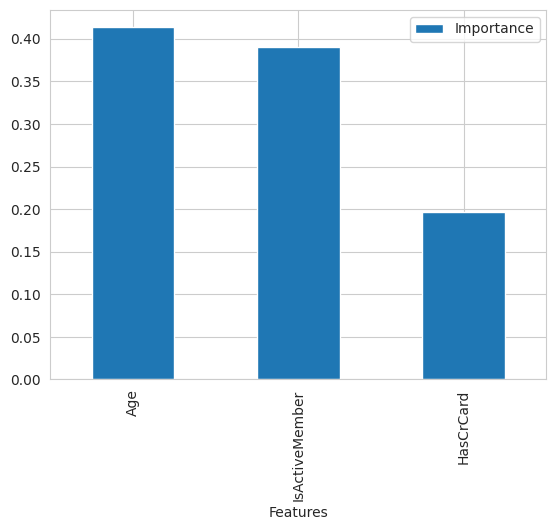

In [23]:
# Creating Dataframe
df_feature_importance = (pd.DataFrame(data={
    'Features': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Arranging best features in order
best_features = df_feature_importance['Features'].to_list()

# Plotting best features against importance
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Features'].to_list()}")

df_feature_importance.plot(kind='bar', x='Features', y='Importance')
plt.show()

# Evaluate Pipeline on Train and Test Sets

Evaluating pipeline performance using classification report and confusion matrix.

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluating against metrics defined in ML business case
* 70% Recall for Will-Exit on train and test set
* 70% Precision for No-Exit on train and test set 

In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No-Exit', 'Will-Exit'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual No-Exit Actual Will-Exit
Prediction No-Exit             4387             1103
Prediction Will-Exit           2007             5291


---  Classification Report  ---
              precision    recall  f1-score   support

     No-Exit       0.80      0.69      0.74      6394
   Will-Exit       0.72      0.83      0.77      6394

    accuracy                           0.76     12788
   macro avg       0.76      0.76      0.76     12788
weighted avg       0.76      0.76      0.76     12788
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual No-Exit Actual Will-Exit
Prediction No-Exit             1064              125
Prediction Will-Exit            501              310


---  Classification Report  ---
              precision    recall  f1-score   support

     No-Exit       0.89      0.68      0.77      1565
   Will-Exit       0.38      0.71      0.50       435

    accuracy             

# **Refit Pipeline with Best Features** 

**As per theory we only use best features to refit ML pipeline to obtain similar results, however in this project we also need to balance the target variable in Train Set using SMOTE.**

1. Best features identified

In [51]:
best_features = ['Age', 'IsActiveMember', 'HasCrCard','CreditScore','NumOfProducts']

2. Creating new pipeline for Data Cleaning and Feature Engineering. We are not using Ordinal encoder as those features(Gender and Geography) has been dropped.

In [52]:
def PipelineDataCleanAndFeatEng():
    pipeline_base = Pipeline([
        ("log", vt.LogTransformer(variables=['Age']) )                                              
    ])

    return pipeline_base


PipelineDataCleanAndFeatEng()

Pipeline(steps=[('log', LogTransformer(variables=['Age']))])

3. Modifying classification pipeline as there is no feature selection required anymore as we are aware of best features.

In [53]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

4. Splitting Train and Test Set

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Exited'], axis=1),
    df['Exited'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7996, 9) (7996,) (2000, 9) (2000,)


5. Filtering the most important variables

In [55]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(7996, 5) (7996,) (2000, 5) (2000,)


### Managing Target Imbalance

1. Fitting train and test sets with Data cleaning and Feat Eng Pipeline.

In [56]:
pipeline_preprocessed = PipelineDataCleanAndFeatEng()
X_train = pipeline_preprocessed.fit_transform(X_train)
X_test = pipeline_preprocessed.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(7996, 5) (7996,) (2000, 5) (2000,)


2. Checking target distribution in train set

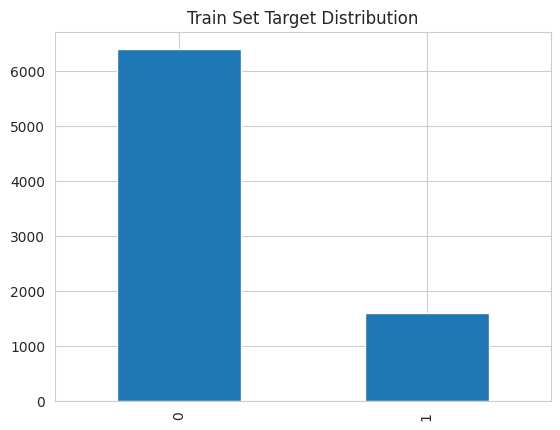

In [57]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [58]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(12788, 5) (12788,) (2000, 5) (2000,)


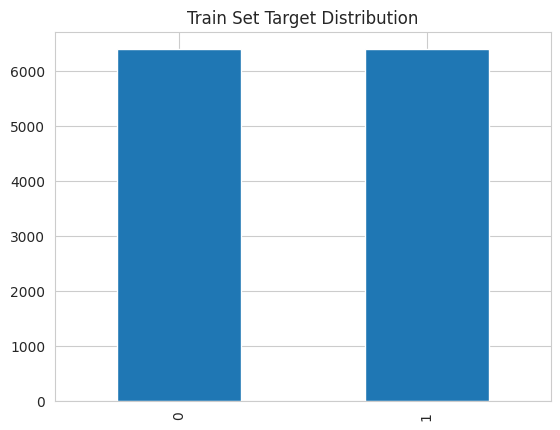

In [59]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

In [60]:
best_model

'AdaBoostClassifier'

In [61]:
models_search = {
   "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
}

In [62]:
best_parameters

{'model__algorithm': 'SAMME',
 'model__learning_rate': 0.5,
 'model__n_estimators': 10}

In [63]:
params_search = {'AdaBoostClassifier':  {
 'model__algorithm': ['SAMME'],
 'model__learning_rate': [0.5],
 'model__n_estimators': [10]
 },
}
params_search

{'AdaBoostClassifier': {'model__algorithm': ['SAMME'],
  'model__learning_rate': [0.5],
  'model__n_estimators': [10]}}

In [64]:
from sklearn.metrics import recall_score, make_scorer
best_alg = HyperparameterOptimizationSearch(models=models_search, params=params_search)
best_alg.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [65]:
grid_search_summary, grid_search_pipelines = best_alg.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__algorithm,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.667709,0.746961,0.813772,0.055407,SAMME,0.5,10


In [66]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5,
                                    n_estimators=10, random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['IsActiveMember', 'Age']


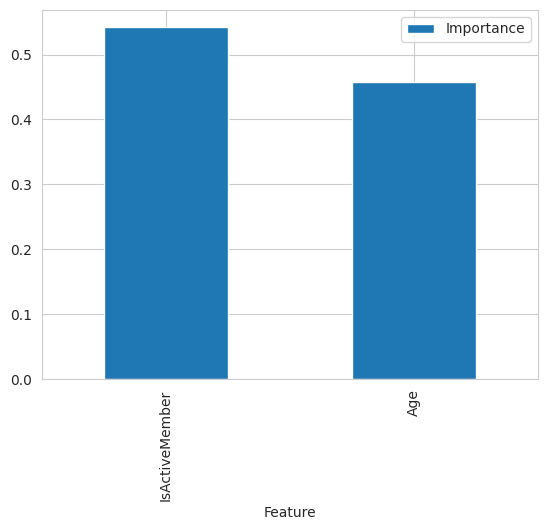

In [73]:
best_features = ['Age','IsActiveMember']


# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [67]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No-Exit', 'Will-Exit'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual No-Exit Actual Will-Exit
Prediction No-Exit             3512             1506
Prediction Will-Exit           2882             4888


---  Classification Report  ---
              precision    recall  f1-score   support

     No-Exit       0.70      0.55      0.62      6394
   Will-Exit       0.63      0.76      0.69      6394

    accuracy                           0.66     12788
   macro avg       0.66      0.66      0.65     12788
weighted avg       0.66      0.66      0.65     12788
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual No-Exit Actual Will-Exit
Prediction No-Exit              900              154
Prediction Will-Exit            665              281


---  Classification Report  ---
              precision    recall  f1-score   support

     No-Exit       0.85      0.58      0.69      1565
   Will-Exit       0.30      0.65      0.41       435

    accuracy             